# [[데이콘] 영화 리뷰 감성 분석](https://dacon.io/competitions/official/235995/overview/description)

**참고 사이트**  
[[기업은행] 영화 리뷰 감성 분석 PBL 1](https://dacon.io/competitions/official/235995/codeshare/6528?page=1&dtype=recent)  
[22. 자연어 처리하기 1](https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html)

## 1. 데이터 살펴보기
### 1) 데이터 불러오기

In [1]:
# 데이터를 불러오고 살펴보기 위한 라이브러리
import pandas as pd
import numpy as np

# 시각화를 하기 위한 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline

import sys
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
train = pd.read_csv('data/[기업은행 혁신리그 사전강의] 영화 리뷰 감성 분석/train.csv')[['document', 'label']]
test = pd.read_csv('data/[기업은행 혁신리그 사전강의] 영화 리뷰 감성 분석/test.csv')[['document']]
submission = pd.read_csv('data/[기업은행 혁신리그 사전강의] 영화 리뷰 감성 분석/sample_submission.csv')

In [3]:
print(len(train))
print(len(test))

150000
50000


In [4]:
print(train.head())
print('\n')
print(train.tail())

                                            document  label
0                                아 더빙.. 진짜 짜증나네요 목소리      0
1                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2                                  너무재밓었다그래서보는것을추천한다      0
3                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


                               document  label
149995              인간이 문제지.. 소는 뭔죄인가..      0
149996                    평점이 너무 낮아서...      1
149997  이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998      청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999         한국 영화 최초로 수간하는 내용이 담긴 영화      0


### 2) 데이터 정제하기
#### (1) 중복 행 제거

In [5]:
# 중복 행 찾기
train[train['document'].duplicated()] # 총 3,817행 존재

,document,label
1058,4,0
1097,쵝오,1
1248,최고,1
1483,최고,1
1707,재밌다,1
...,...,...
149919,짱,1
149949,OO 영화,0
149960,지루하다,0
149966,1,0


In [6]:
# 중복 행 제거
train.drop_duplicates(['document'], inplace=True)
len(train)

146183

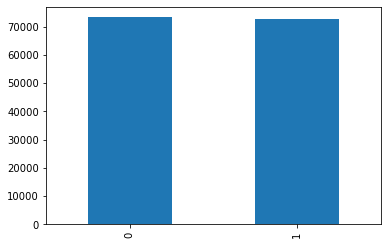

In [7]:
# 중복을 제거한 train.label 분포
train.label.value_counts().plot(kind='bar');

In [8]:
train.label.value_counts() # 0(부정) > 1(긍정)

0    73342
1    72841
Name: label, dtype: int64

#### (2) 결측치 찾기

In [9]:
print('결측치 개수: {}개'.format(train['document'].isnull().sum()))

결측치 개수: 1개


In [10]:
train[train['document'].isnull()]

,document,label
25857,NaN,1


In [11]:
# 결측치 제거
train = train.dropna(how='any')  # how = 'any' : row 또는 column에 NaN값이 1개만 있어도 drop
train.isnull().values.any()

False

In [12]:
# 결측치 제거 후, 라벨 분포
train.label.value_counts() # 0(부정) > 1(긍정)

0    73342
1    72840
Name: label, dtype: int64

### 3) validation 셋을 활용한 검증

In [13]:
from sklearn.model_selection import train_test_split

X = train[['document']]
y = train[['label']]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.5, random_state=24)

In [14]:
print(f"X_train.shape : {X_train.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"X_valid.shape : {X_valid.shape}")
print(f"y_valid.shape : {y_valid.shape}")

X_train.shape : (73091, 1)
y_train.shape : (73091, 1)
X_valid.shape : (73091, 1)
y_valid.shape : (73091, 1)


In [15]:
# 예시: label을 모두 1로 가정하여 y_valid와 비교하여 정확도 평가
pred = y_valid.copy() # y_valid 값을 복사
pred[['label']] = 1 # label 값을 모두 1로 변환

from sklearn.metrics import accuracy_score
print(accuracy_score(y_valid, pred))

0.4998152987371906


## 2. 텍스트 전처리
### 1) 정규 표현식
- re 모듈 사용
- [a-zA-Z]: 모든 영어 문자
- [**^**a-zA-Z]: 영어 문자를 제외한 문자열

- 메타 문자(meta characters)
    - 원래 그 문자가 아닌 특별한 용도로 사용하는 문자
    - [ㄱ-ㅎㅏ-ㅣ가-힣]: 모든 한글 문자
    - [**^**ㄱ-ㅎㅏ-ㅣ가-힣]: **한글을** 제외한 모든 문자
    - [**^**ㄱ-ㅎㅏ-ㅣ가-힣 ]: **한글과 공백을** 제외한 모든 문자

In [16]:
import re

# 예시
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub("[^a-zA-Z]", "", eng_text)) # 영어 문자를 제외한 모든 문자열을 "(공백 = 제거)"으로 변경

doyouexpectpeopletoreadtheFAQetcandactuallyaccepthardatheism


In [17]:
# 특수 문자 제거 전
train.head()

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [18]:
# 특수문자 제거하기 - 한글과 공백을 제외한 나머지 문자열을 모두 제거
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", regex=True)
train[:5]

,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0
3,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [19]:
# 공백만 존재하거나 빈 값이 있는 행이 있다면 Null값으로 변경한 후, Null값이 존재하는지 확인
train['document'] = train['document'].str.replace("^ +", "", regex=True) # 공백(^ +)을 빈 값으로 변경
train['document'].replace("", np.nan, inplace=True, regex=True) # 빈 값을 nan로 변경
train.isnull().sum() # nan 존재 확인

document    789
label         0
dtype: int64

In [20]:
# nan값이 있는 상위 5개 추출
train[train['document'].isnull()].head()

,document,label
404,NaN,0
412,NaN,1
470,NaN,1
584,NaN,0
593,NaN,0


In [21]:
# nan 행 삭제
train = train.dropna(how='any', axis=0)
len(train)

145393

### 2) 토큰화
- 불용어: stopwords로 언어 분석을 할 때 의미가 없는 단어와 조사 등을 의미함
- 토큰화: 텍스트에서 **토큰**이라 불리는 단위로 나누는 작업
    - 토큰의 기준: 단어/단어구/문자열
    - 보통 의미 있는 단위로 토큰을 정함
    - 영어의 토큰화: 주로 띄어쓰기 기준
    - **한글의 토큰화: 형태소 기준**

In [22]:
from konlpy.tag import Okt

okt = Okt()
print("Okt 형태소 분석 stem=True 적용: ", okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem=True)) # stem = true: 일정 수준의 정규화 수행(이런 → 이렇다, 만드는 → 만들다)
print("Okt 형태소 분석 stem=True 미적용: ", okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔'))

Okt 형태소 분석 stem=True 적용:  ['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']
Okt 형태소 분석 stem=True 미적용:  ['와', '이런', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만드는', '게', '나을', '뻔']


In [ ]:
# 불용어 예시
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 토큰화 + 불용어 제거
train_feature = [] # 토큰화 + 불용어 제거가 적용된 데이터의 저장 공간
for sentence in tqdm(train['document']):
    tokenized_sentences = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentences if not word in stopwords] # 불용어 제거
    train_feature.append(stopwords_removed_sentence)

 64%|███████████████████████████████████████████████▍                          | 93265/145393 [11:43<04:28, 193.93it/s]

In [ ]:
# 리스트 컴프리헨션 펼쳐보기
# stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]

stopwords_removed = [] # 불용어 제거된 결과 데이터의 저장 공간
for word in tokenized_sentences: # 토큰화된 단어
    if word not in stopwords: # 토큰화된 단어 != 불용어
        stopwords_removed.append(word)
        
print("-"*67)
print(f"불용어 : {stopwords}")
print('\n----------------------토큰화 + 불용어 제거하기 전------------------------')
print(f"tokenized_sentences : {tokenized_sentences}")
print('\n----------------------토큰화 + 불용어 제거된 결과 확인--------------------')
print(f"stopwords_removed : {stopwords_removed}")

In [ ]:
# 토큰화 + 불용어 제거된 데이터가 모인 리스트 확인
train_feature[:3]

### 3) 정수 인코딩
- 컴퓨터는 모든 것을 0과 1로만 표현하므로 train/test 데이터의 텍스트를 정수로 바꿔주는 **인코딩** 작업 필요
- Keras의 정수 인코딩 기능을 지원하는 전처리 도구 Tokenizer() 사용
    - Tokenizer는 토큰화 기능도 지님
    - 각 단어에 **등장 빈도수가 높은 순서대로** 정수가 부여됨
    - 빈도수가 낮은 단어들은 자연어 처리를 할 때 제외함

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_feature) # fit_on_texts: 문자 데이터를 입력받아서 리스트의 형태로 변환
print(tokenizer.word_index) # 가장 낮은 정수를 얻은 '영화' 단어의 등장 빈도수가 가장 높음

일반적으로 빈도수가 낮은 단어들은 자연어 처리를 할 때 제외하므로 빈도수가 3회 미만(임의로 정함)인 단어들의 비중을 탐색함

In [ ]:
# 임의로 빈도수가 3회 미만인 단어 비중 탐색
# 임계값 설정
threshold = 3

# 전체(train) 단어
total_cnt = len(tokenizer.word_index) # 단어의 개수
total_freq = 0 # 단어의 등장 빈도수

# 단어의 등장 빈도수가 threshold(=3)보다 작은 단어
rare_cnt = 0 # 단어의 개수
rare_freq = 0 # 단어의 등장 빈도수

# 단어와 빈도수의 쌍(pair)을 key와 value로 받음
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    
    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt += 1
        rare_freq += value
        
print('전체 단어의 수 :', total_cnt)
print('등장 빈도가 3번 미만인 단어의 수 :', rare_cnt)
print('단어 집합에서 3번 미만인 단어 수의 비율 :', (rare_cnt / total_cnt)*100)
print('단어 집합에서 3번 미만인 단어 등장 빈도 비율 :',(rare_freq / total_freq)*100)

등장 빈도가 2회 이하인 단어들이 절반 이상이지만, 훈련 데이터에서 이들의 등장 비율을 매주 적은 1.87%  
따라서 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 중요하지 않으므로 이 단어들을 정수 인코딩 과정에서 제외함

In [ ]:
# 전체 단어 개수 중 빈도수 2 이하인 단어 제거
vocab_size = total_cnt - rare_cnt + 1
print("단어 등장 빈도수가 3 이상인 단어 집합의 크기 : ", vocab_size)

In [ ]:
# 정수 시퀀스로 변환 전(테스트 시퀀스)
train_feature[:3]

In [ ]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(num_words = vocab_size) # num_words: 단어 빈도수가 높은 순으로 num_words개 단어만 사용, 나머지는 고려하지 않음
tokenizer.fit_on_texts(train_feature) # fit_on_texts: 문자 데이터를 입력받아서 리스트의 형태로 변환
train_feature = tokenizer.texts_to_sequences(train_feature) # texts_to_sequences: 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환, 해당 문자열의 각 단어에 인덱스를 부여

In [ ]:
# 정수 시퀀스로 변환한 데이터 확인
train_feature[:3]

In [ ]:
# train셋의 label 데이터형 확인
train['label']

In [ ]:
# 배열 형태로 변환
train_label = np.array(train['label'])
train_label[:3]

### 4) 빈 샘플(empty sample) 제거
위에서 빈도수가 낮은 단어를 삭제했지만, 이들은 완전히 삭제된 것이 아닌 빈(empty) 샘플이 되었다는 것을 의미함  
따라서 빈 샘플들을 완전히 제거해야 함

In [ ]:
# 빈 샘플(empty sample) 제거 전 행의 개수
print(len(train_feature))
print(len(train_label))

In [ ]:
train_feature[0]

In [ ]:
len(train_feature[0])

In [ ]:
# 빈 샘플들의 인덱스
drop_train = [index for index, sentence in enumerate(train_feature) if len(sentence) < 1] # 각 리스트 원소 개수가 1개 미만인 index 번호 추출

# 빈 샘플을 제거
train_feature = np.delete(train_feature, drop_train, axis = 0)
train_label = np.delete(train_label, drop_train, axis = 0)

# 빈 샘플(empty sample) 제거 후 행의 개수
print(len(train_feature))
print(len(train_label))

### 5) 패딩
- 병렬 연산을 위해서 여러 문장의 길이를 임의로 동일하게 맞춰주는 작업으로 **데이터에 특정 값(보통 0)을 채워서** 데이터의 크기(shape)를 조정하는 것입니다.
- 특정 값으로 숫자 0을 사용하고 있다면 제로 패딩(zero padding)이라고 함

In [ ]:
print('리뷰 길이의 최댓값: ', max(len(review) for review in train_feature))
print('리뷰 길이의 평균값: ', sum(map(len, train_feature))/len(train_feature))

plt.hist([len(review) for review in train_feature], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()